# Class Activation Map in Pytorch from Scratch
## with OxfordTPet dataset

*Code Writer: Chaeeun Ryu*

In [1]:
!nvidia-smi

Thu Mar 23 16:57:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:1D:00.0 Off |                  N/A |
| 30%   29C    P8    22W / 350W |   7853MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:1F:00.0 Off |                  N/A |
| 72%   

# Import Libraries

In [2]:
import argparse
import os
import random
import time
import warnings
import sys
import numpy as np
import torch
import torch.nn as nn 
import torchvision.transforms as transforms
from collections import Counter, OrderedDict
import torch.optim
from sklearn.metrics import confusion_matrix
from torchvision.datasets import OxfordIIITPet
import os
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
import torchvision.models as models
import glob
import copy
# from torchvision.models import resnet50, ResNet50_Weights
import torchvision
import matplotlib.pyplot as plt
device =  torch.device('cuda:1')

In [3]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

# Config

In [4]:
from dataclasses import dataclass
@dataclass
class ARGS():
    LR = 0.005
    EPOCHS = 300
    BATCHSIZE = 100
    MOMENTUM = 0.9
    WORKERS = 0
    WEIGHTDECAY = 0
    T_MAX = 150
    CLS_CLASS = 37
    SEG_CLASS = 3
    SIZE = 224
    SEED = 38
    DETACH = 120
    ETA_MIN = 0
    
args = ARGS()

In [5]:
seed_everything(args.SEED)

# Get dataset

In [6]:
transform_train = transforms.Compose([
        transforms.Resize((args.SIZE,args.SIZE)),
        transforms.RandomCrop(args.SIZE, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

transform_val = transforms.Compose([
        transforms.Resize((args.SIZE,args.SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

In [7]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
_tr_transform = [
        A.Resize(height = args.SIZE, width = args.SIZE,p=1),
        A.Rotate(limit=30,p=0.3),
        A.ColorJitter(p=0.3),
        A.HorizontalFlip(p=0.3),
        A.VerticalFlip(p=0.3),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ]
_val_transform = [
        A.Resize(height = args.SIZE, width = args.SIZE,p=1),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ]
to_tensor = A.Compose([ToTensorV2()])
seg_transform_train = A.Compose(_tr_transform)
seg_transform_val = A.Compose(_val_transform)

#### Datasets

In [8]:
classification_train_dataset = OxfordIIITPet(root='./data', split="trainval", target_types = 'category',download=True, transform=transform_train)
classification_val_dataset = OxfordIIITPet(root='./data', split="test", target_types = 'category',download=True, transform=transform_val)

In [9]:
_segmentation_train_dataset = OxfordIIITPet(root='./data', split="trainval", target_types = 'segmentation',download=True)
_segmentation_val_dataset = OxfordIIITPet(root='./data', split="test", target_types = 'segmentation', download=True)

In [10]:
from torch.utils.data import Dataset, DataLoader
class SegDataset(Dataset):
    def __init__(self, dataset, transform):
        self.tf = transform
        self.dataset = dataset
    
    def __len__(self):
        return self.dataset.__len__()
    
    def __getitem__(self, idx):
        img_tuple, mask_tuple = self.dataset.__getitem__(idx)
        sample = self.tf(image = np.array(img_tuple), mask= np.array(mask_tuple))
        img,mask = sample["image"],sample["mask"]
        mask[mask==2] = 0# convert background (prev: 2) as 0
        mask[mask == 3] = 2# convert outline (prev:3) as 2
        # class info
        # background: 0
        # object: 1
        # outline: 2
        return img,mask

In [11]:
segmentation_train_dataset = SegDataset(_segmentation_train_dataset,seg_transform_train)
segmentation_val_dataset = SegDataset(_segmentation_val_dataset,seg_transform_val)

#### Dataloaders

In [12]:
global classification_loaders
classification_loaders = dict()
classification_train_loader = torch.utils.data.DataLoader(
            classification_train_dataset, batch_size=args.BATCHSIZE, shuffle=True,
            num_workers=args.WORKERS, pin_memory=True)
classification_val_loader = torch.utils.data.DataLoader(
    classification_val_dataset, batch_size=args.BATCHSIZE, shuffle=False,
    num_workers=args.WORKERS, pin_memory=True)

classification_loaders['train_loader'] = classification_train_loader
classification_loaders['val_loader'] = classification_val_loader

# Basic Model

In [38]:
import copy
class BaseCNN(nn.Module):
    def __init__(self, num_classes):
        super(BaseCNN,self).__init__()
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=8,kernel_size=3,stride=1,padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        self.relu = nn.ReLU(inplace = True)
        self.avgpool1 = nn.AvgPool2d(kernel_size=4)        
        self.conv2 = nn.Conv2d(in_channels=8,out_channels=20,kernel_size=3,stride=1,padding=2)
        self.bn2 = nn.BatchNorm2d(20)
        self.relu2 = nn.ReLU(inplace = True)
        self.avgpool2 = nn.AvgPool2d(kernel_size = 4)
        self.GAP = nn.AdaptiveAvgPool2d((1,1))
        self.final_fc = nn.Linear(20,args.CLS_CLASS)
    def forward(self,x):
        x = self.conv1(x)
        #print("after conv1:",x.size())
        x = self.bn1(x)
        #print("after bn1:",x.size())
        x = self.relu(x)
        #print("after relu:",x.size())
        x = self.avgpool1(x)
        #print("after avgpool1:",x.size())
        
        x = self.conv2(x)
        #print("after conv2:",x.size())
        x = self.bn2(x)
        #print("after bn2:",x.size())
        x = self.relu2(x)
        #print("after relu2:",x.size())
        x = self.avgpool2(x)
        feature_map = x.clone()
        #print("after avgpool2:",x.size())
        x = self.GAP(x)
        #print("after GAP:",x.size())
        x = x.flatten(1)
        x = self.final_fc(x)
        return feature_map,x

In [39]:
cnn = BaseCNN(args.CLS_CLASS).to(device)

In [40]:
image_batch,label_batch = next(iter(classification_loaders['train_loader']))
image_batch,label_batch = image_batch.to(device),label_batch.to(device)

In [41]:
_,out = cnn(image_batch)

In [42]:
for name, param in cnn.named_parameters():
    if param.requires_grad:
        print(f"{name}")
        print(f"size: {param.size()}")

conv1.weight
size: torch.Size([8, 3, 3, 3])
conv1.bias
size: torch.Size([8])
bn1.weight
size: torch.Size([8])
bn1.bias
size: torch.Size([8])
conv2.weight
size: torch.Size([20, 8, 3, 3])
conv2.bias
size: torch.Size([20])
bn2.weight
size: torch.Size([20])
bn2.bias
size: torch.Size([20])
final_fc.weight
size: torch.Size([37, 20])
final_fc.bias
size: torch.Size([37])


In [43]:
out.size()

torch.Size([100, 37])

In [44]:
out.flatten(1).size()

torch.Size([100, 37])

# Basic Training

In [47]:
optimizer = torch.optim.Adam(cnn.parameters(),lr=0.05)
criterion = nn.CrossEntropyLoss()

In [48]:
cnn.train()

BaseCNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (avgpool1): AvgPool2d(kernel_size=4, stride=4, padding=0)
  (conv2): Conv2d(8, 20, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (avgpool2): AvgPool2d(kernel_size=4, stride=4, padding=0)
  (GAP): AdaptiveAvgPool2d(output_size=(1, 1))
  (final_fc): Linear(in_features=20, out_features=37, bias=True)
)

In [52]:
import copy
best_acc = 0.
for epoch in range(10):
    epoch_loss = []
    save_acc = []
    for image_batch,label_batch in classification_loaders['train_loader']:
        image_batch,label_batch = image_batch.to(device),label_batch.to(device)
        _,out = cnn(image_batch)
        preds = out.argmax(dim = 1)
        loss = criterion(out,label_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss.append(loss.item())
        save_acc.append((torch.sum((preds==label_batch)*1)/preds.size()[0]).item())
    print("loss:",np.mean(epoch_loss))
    print("acc:",np.mean(save_acc))
    if np.mean(save_acc)>best_acc:
        best_acc = np.mean(save_acc)
        best_model = copy.deepcopy(cnn)
    else:#drop lr
        for g in optimizer.param_groups:
            g['lr'] /= 10
print("train ended")

loss: 3.523773463996681
acc: 0.05905405235652988
loss: 3.5178691438726477
acc: 0.05844594452630829
loss: 3.469747710872341
acc: 0.06912162003887666
loss: 3.4534062694858862
acc: 0.07236486260552664
loss: 3.450088913376267
acc: 0.0746621595242539
loss: 3.4438997668188973
acc: 0.07574324143698087
loss: 3.4423972722646354
acc: 0.07520270090852235
loss: 3.4336578201603247
acc: 0.07945945692827573
loss: 3.4307962043865308
acc: 0.07898648400363084
loss: 3.4315105193370097
acc: 0.08222972692267315
train ended


In [54]:
best_acc

0.08222972692267315

In [57]:
1/37#acc you get randomly

0.02702702702702703

# Draw CAM

In [230]:
input_batch,label_batch = next(iter(classification_loaders['train_loader']))
input_batch,label_batch = input_batch.to(device),label_batch.to(device)

In [232]:
feature_maps,out = best_model(input_batch)

In [233]:
use_img,use_label,use_feature_map,use_out = input_batch[0],label_batch[0],feature_maps[0],out[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


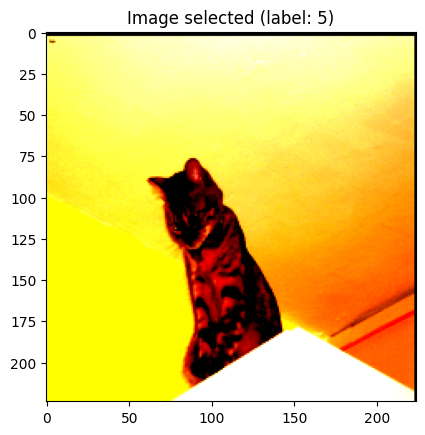

In [234]:
plt.title(f"Image selected (label: {use_label})")
plt.imshow(use_img.permute(1,2,0).detach().cpu().numpy())
plt.show()

## CAM computation

In [235]:
class_idx = 0
for map,w in zip(use_feature_map,W.T):
    if class_idx == 0:
        total_cam = map*w[class_idx]
    else:
        total_cam += map*w[class_idx]
    class_idx +=1

In [236]:
total_cam.size()

torch.Size([14, 14])

In [237]:
use_img.size()

torch.Size([3, 224, 224])

In [238]:
expand_tr = transforms.Resize((224,224))

In [239]:
expanded_cam = expand_tr(total_cam.unsqueeze(0))

In [240]:
expanded_cam.size()

torch.Size([1, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


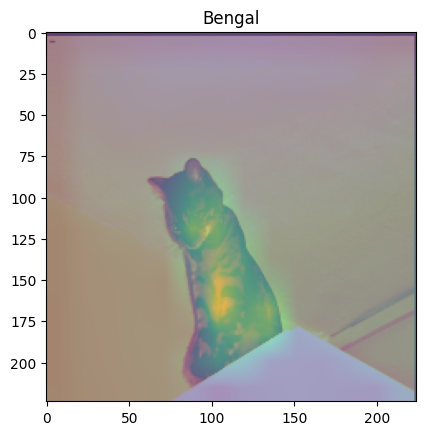

In [241]:
plt.title(f'{classification_train_dataset.classes[use_label]}')
plt.imshow(use_img.permute(1,2,0).detach().cpu().numpy(),alpha = 0.5)
plt.imshow(expanded_cam[0].detach().cpu().numpy(),alpha = 0.5)
plt.show()